In [1]:
!pip install "tensorflow>=2.15.0"

In [2]:
!pip install --upgrade tensorflow-hub

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/drive/MyDrive

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/content/drive/MyDrive'
/content


In [4]:
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Set Up

In [5]:
# We now set the directory to access the data
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

# The folder with the data and this script should be saved in your drive.
script_name = 'CourseWork_v2.ipynb'
script_path = find(script_name, '/content/gdrive/My Drive')
#DIRECTORY = '.'#os.path.dirname(script_path)
# If your Drive is too large and the "find" function takes to much time, you can set the directory manually :

#SUMMARY_PATH = '/content/drive/MyDrive/MutualFundSummary'
#SUMMARY_LABELS_PATH = '/content/drive/MyDrive/MutualFundLabels.csv'

DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app'

SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

**Utils**

In [6]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/content/drive/MyDrive', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/content/drive/MyDrive', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

# Data Preprocessing

**Process lables data**

In [7]:
# read data
#labels = pd.read_csv('/content/MutualFundLabels.csv')
labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundLabels.csv')


In [8]:
len(labels)

467

In [9]:
labels.tail()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration
462,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified
463,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified
464,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified
465,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified
466,0001710607-18-000172,American Century STOXX U.S. Quality Value ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified


In [10]:
labels['Portfolio composition'].value_counts()

Portfolio composition
Investment grade securities                            183
Listed Equities                                        177
Sub-investment grade securities or emerging markets    107
Name: count, dtype: int64

In [11]:
labels[' Concentration'].value_counts()

 Concentration
Diversified                                       375
Concentrated by issuer / sector / jurisdiction     92
Name: count, dtype: int64

In [12]:
labels['Performance fee?'].isna().sum()

447

In [13]:
labels = labels.drop('Performance fee?', axis=1)
labels.head()

,id,fund_name,Ivestment Strategy,Leverage?,Portfolio composition,Concentration
0,0000051931-18-000151,American Funds College 2018 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
1,0000051931-18-000151,American Funds College 2021 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
2,0000051931-18-000151,American Funds College 2024 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
3,0000051931-18-000151,American Funds College 2027 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
4,0000051931-18-000151,American Funds College 2030 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified


In [14]:
labels['Leverage?'].value_counts()

Leverage?
No     275
Yes    192
Name: count, dtype: int64

In [15]:
labels['Ivestment Strategy'].value_counts()

Ivestment Strategy
Equity Long Only (Low Risk)          248
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Commodities Fund (Low Risk)            1
Name: count, dtype: int64

The result reflects an imbalance in your dataset, with "Long Short Funds (High Risk)" and "Commodities Fund (Low Risk)" having significantly fewer instances compared to other investment strategies. This imbalance can lead to issues such as model bias towards the majority classes and a risk of overfitting to the few examples of the minority classes. Given these potential problems, it seems reasonable to exclude these underrepresented categories to improve the model's overall predictive accuracy and reliability.

In [16]:
removes = labels.loc[(labels['Ivestment Strategy']=='Long Short Funds (High Risk)')| (labels['Ivestment Strategy']=='Commodities Fund (Low Risk)')]
removes

,id,fund_name,Ivestment Strategy,Leverage?,Portfolio composition,Concentration
296,0001193125-18-285341,Columbia Commodity Strategy Fund,Commodities Fund (Low Risk),Yes,Investment grade securities,Diversified
301,0001193125-18-285341,Columbia Mortgage Opportunities Fund,Long Short Funds (High Risk),Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction
423,0001580642-18-006021,Anchor Tactical Equity Strategies Fund,Long Short Funds (High Risk),Yes,Investment grade securities,Diversified
424,0001580642-18-006021,Anchor Tactical Municipal Strategies Fund,Long Short Funds (High Risk),Yes,Investment grade securities,Diversified
425,0001591556-18-000016,Dreyfus Alternative Diversifier Strategies Fund,Long Short Funds (High Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified


In [17]:
labels_clean = labels.drop(removes.index)
len(labels_clean)

462

In [18]:
labels_clean['Ivestment Strategy'].value_counts()

Ivestment Strategy
Equity Long Only (Low Risk)          248
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Name: count, dtype: int64

**Process text data**

In [19]:
fund_names, summaries = get_data(SUMMARY_PATH)

In [20]:
len(fund_names)

545

In [21]:
type(fund_names)

list

In [22]:
cleaned_fund_names = labels_clean['fund_name'].tolist()
fund_name_counts = {name: 0 for name in fund_names}

for name in fund_names:
    if name in cleaned_fund_names:
        fund_name_counts[name] += 1

single_occurrences = {name: count for name, count in fund_name_counts.items() if count == 1}

print(f"Number of matching fund names that appear exactly once: {len(single_occurrences)}")


Number of matching fund names that appear exactly once: 461


In [23]:
multiple_occurrences = {name: count for name, count in fund_name_counts.items() if count > 1}

if multiple_occurrences:
    print(f"There are fund names that appear more than once:")
    for name, count in multiple_occurrences.items():
        print(f"{name}: {count} times")
else:
    print("No fund names appear more than once.")

No fund names appear more than once.


In [24]:
labels_clean_filtered = labels_clean[labels_clean['fund_name'].isin(fund_names)]
labels_clean_filtered

,id,fund_name,Ivestment Strategy,Leverage?,Portfolio composition,Concentration
0,0000051931-18-000151,American Funds College 2018 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
1,0000051931-18-000151,American Funds College 2021 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
2,0000051931-18-000151,American Funds College 2024 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
3,0000051931-18-000151,American Funds College 2027 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
4,0000051931-18-000151,American Funds College 2030 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
...,...,...,...,...,...,...
462,0001710607-18-000172,American Century Diversified Corporate Bond ETF,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified
463,0001710607-18-000172,American Century Diversified Municipal Bond ETF,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified
464,0001710607-18-000172,American Century Quality Diversified Internati...,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified
465,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified


In [25]:
df_summaries = pd.DataFrame(data={'fund_name':fund_names, 'summary':summaries})
df_summaries

,fund_name,summary
0,AB Arizona Portfolio,AB Arizona Portfolio\n------------------------...
1,AB Asia ex-Japan Equity Portfolio,AB ASIA EX-JAPAN EQUITY PORTFOLIO\n-----------...
2,AB Credit Long/Short Portfolio,AB CREDIT LONG/SHORT PORTFOLIO\n--------------...
3,AB Balanced Wealth Strategy Portfolio,AB VPS BALANCED WEALTH STRATEGY PORTFOLIO\n---...
4,AB Bond Inflation Strategy,SUMMARY INFORMATION\n-------------------------...
...,...,...
540,Western Asset Intermediate Maturity California...,Investment objective\n\nThe fund seeks to prov...
541,Variable Portfolio - Victory Sycamore Establis...,SUMMARY OF CTIVPSM – VICTORY SYCAMORE ESTABLIS...
542,Western Asset Intermediate Maturity New York M...,Investment objective\n\nThe fund seeks to prov...
543,Western Asset Massachusetts Municipals Fund,Investment objective\n\nThe fund seeks to prov...


In [26]:
merge = labels_clean_filtered.merge(df_summaries, on=['fund_name'], how='left')
merge.tail()

,id,fund_name,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
456,0001710607-18-000172,American Century Diversified Corporate Bond ETF,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,Fund Summary\nInvestment Objective\nThe fund s...
457,0001710607-18-000172,American Century Diversified Municipal Bond ETF,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,Fund Summary\nInvestment Objective\nThe fund s...
458,0001710607-18-000172,American Century Quality Diversified Internati...,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified,Fund Summary\nInvestment Objective\nThe fund s...
459,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,Fund Summary\nInvestment Objective\nThe fund s...
460,0001710607-18-000172,American Century STOXX U.S. Quality Value ETF,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,Fund Summary\nInvestment Objective\nThe fund s...


**Train test split**

In [27]:
X, X_test, y, y_test = train_test_split(merge['summary'], merge['Ivestment Strategy'], test_size=0.2, random_state=42)

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42)

**Preprocess the texts**

In [29]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [30]:
# clean and tokenize without lemmatizing
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

In [31]:
train_text_words = np.concatenate([tokenizer(summary) for summary in X_train])

In [32]:
train_text_words[:20]

array(['mainstay', 'vp', 'epoch', 'u.s.', 'small', 'cap', 'portfolio',
       'investment', 'objective', 'portfolio', 'seeks', 'long-term',
       'capital', 'appreciation', 'investing', 'primarily', 'securities',
       'small-cap', 'companies', 'fees'], dtype='<U44')

# Skip-gram Model

**Process the skip-gram model input**

In [33]:
# Training parameters
batch_size = 128
num_epochs = 2

# Word2vec parameters
embedding_size = 50
max_vocabulary_size = 5000
min_occurrence = 10
skip_window = 3
num_skips = 4

In [34]:
count = [('UNK', -1)]
count.extend(collections.Counter(train_text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        break

In [35]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [36]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 2821


In [37]:
data = list()
unk_count = 0
for word in train_text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [38]:
print(data[:20])

[914, 613, 1946, 45, 411, 354, 7, 3, 119, 7, 221, 275, 69, 532, 22, 246, 5, 986, 23, 13]


In [39]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [40]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

**Train the skip-gram model**

In [41]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    autoencoder = Model(input_word, decoded)
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [42]:
encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2821)]            0         
                                                                 
 dense (Dense)               (None, 50)                141100    
                                                                 
 dense_1 (Dense)             (None, 2821)              143871    
                                                                 
Total params: 284971 (1.09 MB)
Trainable params: 284971 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

<ipython-input-43-a9705c45700e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0221
Epoch 2/2
3990/3990 [==============================] - 27s 7ms/step - loss: 0.0027


In [44]:
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [45]:
word2vec = {w : vecotrize(w) for w in word2id.keys()}

1/1 [==============================] - 0s 27ms/step


In [46]:
save_word2vec('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/train_word2vec')

In [47]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''","’"]+["]","[","*"]+['doe', 'ha', 'wa'] +['--']+ [''])

In [48]:
max_features = 18
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=list(stop_words), max_features=max_features)
tfidf_train = tfidf.fit_transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [49]:
key_words = tfidf.get_feature_names_out() # 常用关键词
print(key_words)

['class' 'company' 'expense' 'fee' 'fund' 'index' 'investment' 'market'
 'may' 'performance' 'portfolio' 'return' 'risk' 'security' 'share' 'tax'
 'value' 'year']


In [50]:
def get_n_closer(word, n, word2vec):
    vect = word2vec[word]
    dist_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    closer_words = []
    for _ in range(n):
        min_key = min(dist_dict.keys(), key=lambda k: dist_dict[k])
        closer_words.append(min_key)
        del dist_dict[min_key]
    return closer_words

##knowledge base
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base


In [51]:
knowledge_base = create_knowledge_base(5, word2vec, key_words)
print(knowledge_base)

{'receiving', 'return', 'company', 'beginning', 'trust', 'share', 'countries', 'market', 'illustrates', 'calculated', 'complex', 'served', 'age', 'fund', 'year', 'n', 'withdrawing', 'communications', 'underperform', 'midcap®', 'security', 'proportions', 'transact', 'public-', 'solely', 'past', 'approaches', 'ended', 'furthermore', 'utilize', 'investment', 'operation', 'dates', 'rule', 'require', 'figure', 'expense', 'industrials', 'relating', 'financing', 'rises', 'stream', 'declared', 'asia', 'lead', 'regarded', 'growth-and-income', 'opening', 'link', 'environmental', 'term', 'agent', 'reed', 'payable', 'class', 'summarized', 'sudden', 'expected', 'risk', 'performance', 'model', 'assurance', 'index', 'remains', 'r', 'defensive', 'yielding', 'attract', 'capitalization', 'may', 'shares', 'allianzgi', 'value', 'complement', 'military', 'origination', 'benchmarks', 'fee', 'tax', 'c', 'portfolio', 'float-adjusted', 'involved', 'improving', 'able', 'innovation', 'detrimental', 'example', 'f

In [52]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)



# Measure Distance

In [53]:
#prepare the train,validation and test dataframe
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_valid)
X_test_df = pd.DataFrame(X_test)

In [54]:
X_valid_df

,summary
219,Janus Henderson Forty Portfolio\nTicker:\tJACA...
427,Fund Summary Information\nFederated MDT Small ...
117,Arizona Municipal Income Fund\n\nInvestment Ob...
13,Investment objective The fund’s investment obj...
351,Franklin FTSE France ETF\n\nInvestment Goal\n\...
...,...
210,SUMMARY OF CTIVPSM – OPPENHEIMER INTERNATIONAL...
139,MFS South Carolina Municipal Bond Fund\n\n \n\...
373,Franklin LibertyQ U.S. Equity ETF\n\nInvestmen...
345,Franklin FTSE Australia ETF\n\nInvestment Goal...


In [55]:
X_test_df

,summary
225,Janus Henderson Overseas Portfolio\nTicker:\tN...
30,New World Fund\n\nInvestment objective The fun...
39,American Funds Moderate Growth and Income Port...
222,Janus Henderson Global Technology Portfolio\nT...
124,Summary of Key Information\n\n \n\nInvestment ...
...,...
22,International Fund\n\nInvestment objective The...
358,Franklin FTSE Mexico ETF\n\nInvestment Goal\n\...
46,American Funds 2010 Target Date Retirement Fun...
168,Janus Henderson Global Life Sciences Fund\nTic...


In [56]:
X_train_df['sentences_distance'] = X_train_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_valid_df['sentences_distance'] = X_valid_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)


In [57]:
X_test_df['sentences_distance'] = X_test_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [58]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)
X_train_df['sentences_match'] = X_train_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_valid_df['sentences_match'] = X_valid_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_test_df['sentences_match'] = X_test_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)

In [59]:
# produce train_X and test_X
train_X = X_train_df['sentences_match'].values
train_X = [' '.join(tokenizer(txt)) for txt in train_X]

valid_X = X_valid_df['sentences_match'].values
valid_X = [' '.join(tokenizer(txt)) for txt in valid_X]

test_X = X_test_df['sentences_match'].values
test_X = [' '.join(tokenizer(txt)) for txt in test_X]

In [60]:
# produce train_y and valid_y
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
encoded_train_y = encoder.fit_transform(y_train)
label_train_y = to_categorical(encoded_train_y, num_classes=3)
encoded_valid_y = encoder.transform(y_valid)
label_valid_y = to_categorical(encoded_valid_y, num_classes=3)

In [61]:
label_train_y

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1

In [62]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.



In [63]:
keras_tokenizer = Tokenizer(num_words=num_words)

keras_tokenizer.fit_on_texts(train_X)

word_index = keras_tokenizer.word_index

sequences_train = keras_tokenizer.texts_to_sequences(train_X)
sequences_valid = keras_tokenizer.texts_to_sequences(valid_X)
sequences_test = keras_tokenizer.texts_to_sequences(test_X)

# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_valid = pad_sequences(sequences_valid, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')


In [64]:
# create our embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [65]:
len(feature_train)

294

In [66]:
len(label_train_y)

294

# classifier

CNN

In [67]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 3, activation = 'softmax'))

    CNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return CNN

CNN_model = create_CNN_model()
print(feature_train)
CNN_history = CNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=100)


[[1.337e+03 1.500e+01 3.080e+02 ... 1.000e+00 6.300e+01 1.000e+00]
 [2.700e+01 1.100e+01 1.910e+02 ... 2.000e+00 3.040e+02 1.630e+02]
 [4.900e+01 1.210e+02 1.450e+02 ... 1.280e+02 6.500e+01 8.120e+02]
 ...
 [1.200e+01 1.210e+02 4.050e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.530e+02 3.070e+02 2.000e+00 ... 3.200e+02 1.460e+02 1.080e+02]
 [1.200e+01 5.200e+01 1.130e+02 ... 1.810e+02 3.520e+02 1.000e+00]]
Epoch 1/800
3/3 [==============================] - 8s 109ms/step - loss: 1.0395 - accuracy: 0.4762
Epoch 2/800
3/3 [==============================] - 0s 6ms/step - loss: 1.0231 - accuracy: 0.5476
Epoch 3/800
3/3 [==============================] - 0s 6ms/step - loss: 1.0065 - accuracy: 0.5442
Epoch 4/800
3/3 [==============================] - 0s 6ms/step - loss: 0.9746 - accuracy: 0.5680
Epoch 5/800
3/3 [==============================] - 0s 6ms/step - loss: 0.9628 - accuracy: 0.5714
Epoch 6/800
3/3 [==============================] - 0s 7ms/step - loss: 0.9780 - accuracy: 0.5748
Epoch 7/

In [68]:
y_valid_CNN = CNN_model.predict(feature_valid)

3/3 [==============================] - 1s 112ms/step


In [69]:
len(y_valid_CNN)

74

In [70]:
# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

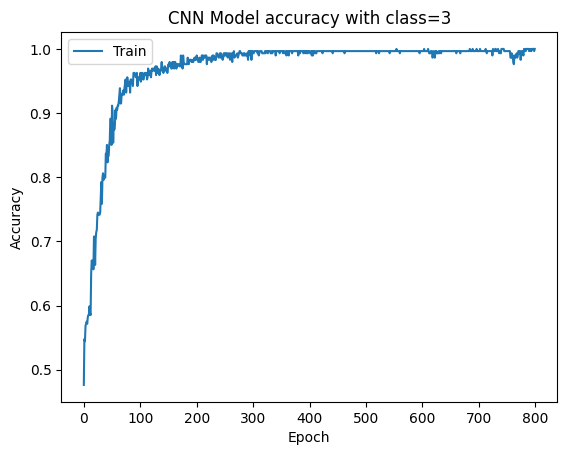

In [71]:
plt.plot(CNN_history.history['accuracy'])
plt.title('CNN Model accuracy with class=3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

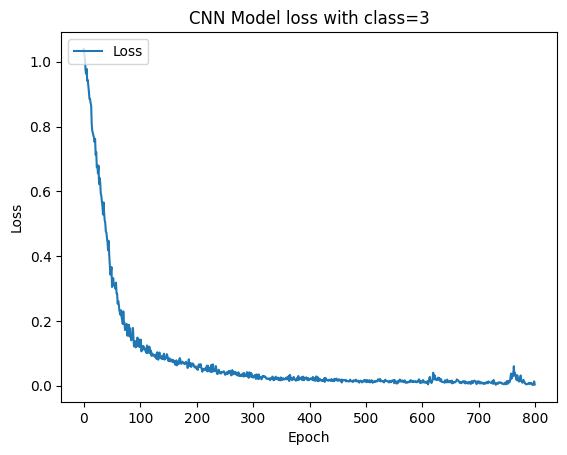

In [72]:
# Plot training loss values
plt.plot(CNN_history.history['loss'])
plt.title('CNN Model loss with class=3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

0.6891891891891891
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.68      0.69      0.68        36
           2       0.71      0.74      0.72        23

   micro avg       0.69      0.69      0.69        74
   macro avg       0.69      0.68      0.68        74
weighted avg       0.69      0.69      0.69        74
 samples avg       0.69      0.69      0.69        74

auc score:  0.7521223155687612


RNN

In [74]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(3, activation='softmax'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return RNN


In [ ]:
RNN_model = create_RNN_model()
RNN_history = RNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=64)


Epoch 1/800
5/5 [==============================] - 6s 25ms/step - loss: 1.1022 - accuracy: 0.3844
Epoch 2/800
5/5 [==============================] - 0s 21ms/step - loss: 0.9705 - accuracy: 0.5714
Epoch 3/800
5/5 [==============================] - 0s 36ms/step - loss: 0.9817 - accuracy: 0.5714
Epoch 4/800
5/5 [==============================] - 0s 33ms/step - loss: 0.9751 - accuracy: 0.5714
Epoch 5/800
5/5 [==============================] - 0s 33ms/step - loss: 0.9713 - accuracy: 0.5714
Epoch 6/800
5/5 [==============================] - 0s 23ms/step - loss: 0.9730 - accuracy: 0.5714
Epoch 7/800
5/5 [==============================] - 0s 17ms/step - loss: 0.9711 - accuracy: 0.5714
Epoch 8/800
5/5 [==============================] - 0s 13ms/step - loss: 0.9692 - accuracy: 0.5714
Epoch 9/800
5/5 [==============================] - 0s 13ms/step - loss: 0.9681 - accuracy: 0.5714
Epoch 10/800
5/5 [==============================] - 0s 13ms/step - loss: 0.9670 - accuracy: 0.5714
Epoch 11/800
5/5 [=

In [ ]:
# Plot training & validation accuracy
plt.plot(RNN_history.history['accuracy'])
plt.title(' RNN Model accuracy with class=3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
# Plot training loss values
plt.plot(RNN_history.history['loss'])
plt.title('RNN Model loss with class=3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()



In [ ]:
# validation with the RNN
y_valid_RNN = RNN_model.predict(feature_valid)
valid_y_RNN = y_valid_RNN.copy()
for i in range(len(y_valid_RNN)):
    j = np.where(y_valid_RNN[i] == np.amax(y_valid_RNN[i]))
    valid_y_RNN[i] = [0, 0, 0]
    valid_y_RNN[i][j] = 1

# print acc and report
print(accuracy_score(label_valid_y,valid_y_RNN))

print(classification_report(label_valid_y,valid_y_RNN))

In [ ]:
y_pred_CNN = CNN_model.predict(feature_test)
pred_y_CNN = y_pred_CNN.copy()
for i in range(len(y_pred_CNN)):
    j = np.where(y_pred_CNN[i] == np.amax(y_pred_CNN[i]))
    pred_y_CNN[i] = [0, 0, 0]
    pred_y_CNN[i][j] = 1

y_pred_RNN = RNN_model.predict(feature_test)
pred_y_RNN = y_pred_RNN.copy()
for i in range(len(y_pred_RNN)):
    j = np.where(y_pred_RNN[i] == np.amax(y_pred_RNN[i]))
    pred_y_RNN[i] = [0, 0, 0]
    pred_y_RNN[i][j] = 1


In [ ]:
cnn_pred_y = pd.Series(np.zeros(len(pred_y_CNN)))
for i in range(len(pred_y_CNN)):
    j = np.where(pred_y_CNN[i] == 1)
    if j == (np.array([0]),):
        cnn_pred_y[i] = 'Balanced Fund (Low Risk)'
    elif j == (np.array([1]),):
        cnn_pred_y[i] = 'Equity Long Only (Low Risk)'
    elif j == (np.array([2]),):
        cnn_pred_y[i] = 'Fixed Income Long Only (Low Risk)'


cnn_predict = pd.DataFrame({'fund name':test_funds,'CNN prediction':cnn_pred_y})
print(cnn_predict)

In [ ]:
rnn_pred_y = pd.Series(np.zeros(len(pred_y_RNN)))
for i in range(len(pred_y_RNN)):
    j = np.where(pred_y_RNN[i] == 1)
    if j == (np.array([0]),):
        rnn_pred_y[i] = 'Balanced Fund (Low Risk)'
    elif j == (np.array([1]),):
        rnn_pred_y[i] = 'Equity Long Only (Low Risk)'
    elif j == (np.array([2]),):
        rnn_pred_y[i] = 'Fixed Income Long Only (Low Risk)'


rnn_predict = pd.DataFrame({'fund name':test_funds,'RNN prediction':rnn_pred_y})
print(rnn_predict)